In [7]:
import os
from functions import clean_word, lematize_word, stem_word
from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (8,6)
sns.set_style('white')

In [ ]:
# set file path and read words
data_path = '/Users/Gabi/PycharmProjects/mueller/data'
file_name = 'mueller_words.txt'
# open file with list of words
f = os.path.join(data_path, file_name)
with open(f, 'r') as openFile:
    mueller_words = openFile.readlines()

In [2]:
mueller_words = [word.strip("\n") for word in mueller_words]
# clean words
cleaned_words = [clean_word(x) for x in mueller_words]
cleaned_words = [w.replace('russian','russia') for w in cleaned_words]

In [3]:
# lematize words - first for nouns then verbs
lem_n_words = [lematize_word(x, 'n') for x in cleaned_words]
lem_v_words = [lematize_word(x, 'v') for x in lem_n_words]
lem_v_counts = Counter(lem_v_words)
print("top 10 words found in report", lem_v_counts.most_common(20))

('top 10 words found in report', [(u'president', 2335), ('russia', 1481), ('trump', 1470), ('meet', 856), ('campaign', 823), ('email', 813), ('cohen', 739), ('investigation', 690), ('justice', 654), (u'state', 647), (u'counsel', 640), (u'tell', 609), ('would', 588), (u'say', 585), ('office', 579), ('flynn', 570), ('department', 563), ('corney', 546), ('mcgahn', 511), (u'statement', 459)])


In [183]:

word_counts = [w for w in lem_v_words if w != '']
word_counts = [w.strip() for w in word_counts if len(w) > 2]

In [184]:
word_counts = [w.encode('utf-8') for w in word_counts]

In [192]:
import pandas as pd
df_words = pd.DataFrame({'words' : word_counts})
df_words.head()

,words
0,department
1,justice
2,atterttey
3,werk
4,predttet


In [201]:
df_wordcounts = df_words.words.value_counts().reset_index()[:21]
df_wordcounts.columns = ['words', 'freq']
df_wordcounts.head()

,words,freq
0,president,2335
1,russia,1481
2,trump,1470
3,meet,856
4,campaign,823


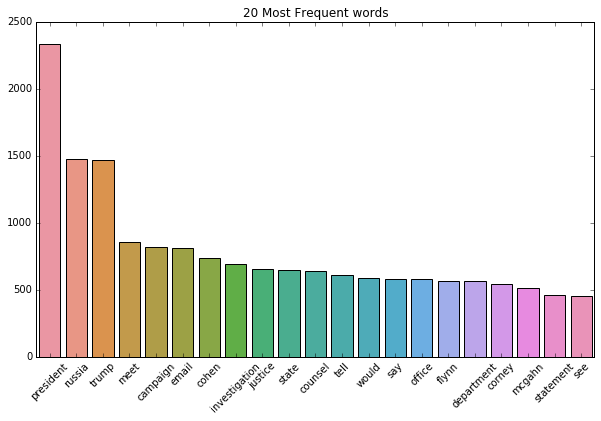

In [212]:
fig, ax = plt.subplots(figsize = (10,6))
_ = sns.barplot(data = df_wordcounts, x = 'words', y = 'freq', ax = ax)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation = 45)
ax.set_title("20 Most Frequent words")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show(fig)

In [9]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import urllib
import requests

In [11]:
wordcloud = WordCloud()

In [29]:
wordcloud = WordCloud(width = 512, height = 512, background_color='white', 
                      max_font_size=50, max_words=150)

In [30]:
wordcloud = wordcloud.generate_from_frequencies(lem_v_counts)

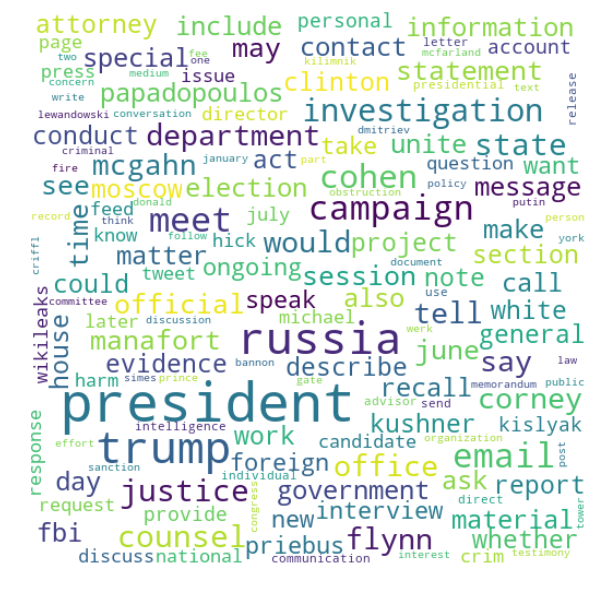

In [35]:
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [227]:
from matplotlib import cm
# generate wordcloud with custom settings 
wordcloud = WordCloud(width = 512, height = 512, background_color='white', colormap=cm.coolwarm,
                      contour_width=10, contour_color='black',
                     max_font_size=70, max_words=150)

In [257]:
mueller_mask = np.array(Image.open("img/mueller_mask.jpeg"))
mueller_mask_2 = np.array(Image.open("img/mueller_mask5.jpg"))
mueller_mask_3 = np.array(Image.open("img/mask2.jpeg"))
# change the shape of the wordcloud
wordcloud.mask = mueller_mask_3

In [258]:
# generate from frequencies 
wordcloud = wordcloud.generate_from_frequencies(lem_v_counts)

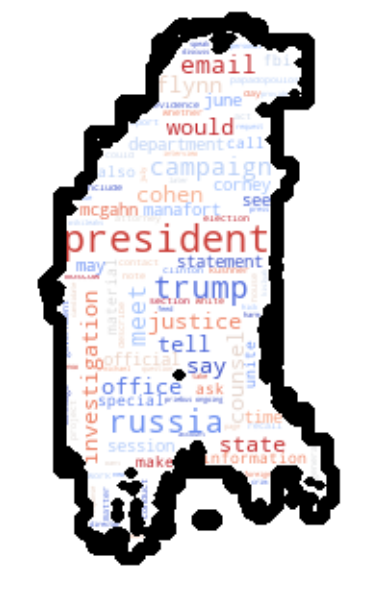

In [259]:
# show plot
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

True